***Importation des Libraires***


In [55]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier  
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import accuracy_score, classification_report

***Exploration et Analyse des Données (EAD)***


1. Analyse des colonnes et distribution des classes

In [56]:
train_data = pd.read_csv('train.En.csv')
train_data.info()
train_data.head()
train_data.describe()
counts =train_data['sarcastic'].value_counts()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3468 entries, 0 to 3467
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Unnamed: 0           3468 non-null   int64  
 1   tweet                3467 non-null   object 
 2   sarcastic            3468 non-null   int64  
 3   rephrase             867 non-null    object 
 4   sarcasm              867 non-null    float64
 5   irony                867 non-null    float64
 6   satire               867 non-null    float64
 7   understatement       867 non-null    float64
 8   overstatement        867 non-null    float64
 9   rhetorical_question  867 non-null    float64
dtypes: float64(6), int64(2), object(2)
memory usage: 271.1+ KB


2. Mesure de la longueur des textes

In [57]:
train_data['word_count'] = train_data['tweet'].apply(lambda x: len(str(x).split()))
train_data['char_count'] = train_data['tweet'].apply(lambda x: len(str(x)))


3. Visualisation des données

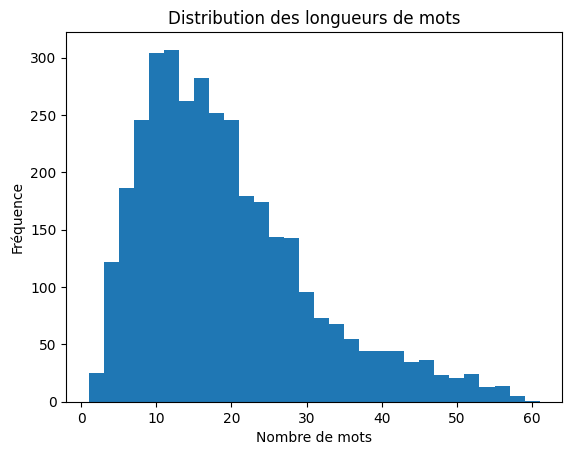

In [58]:
plt.hist(train_data['word_count'], bins=30)
plt.title('Distribution des longueurs de mots')
plt.xlabel('Nombre de mots')
plt.ylabel('Fréquence')
plt.show()

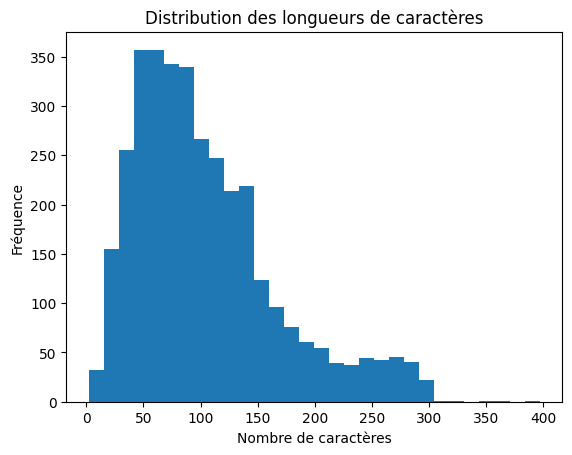

In [59]:
plt.hist(train_data['char_count'], bins=30)
plt.title('Distribution des longueurs de caractères')
plt.xlabel('Nombre de caractères')
plt.ylabel('Fréquence')
plt.show()

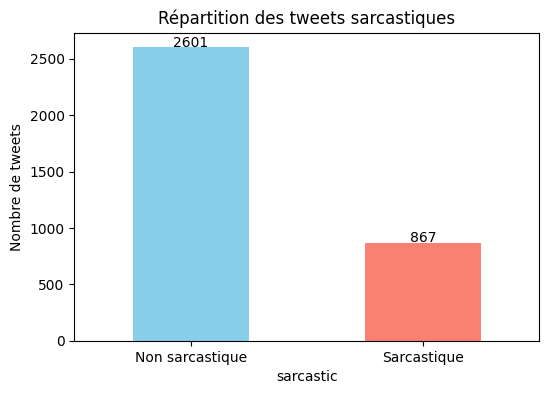

In [60]:
plt.figure(figsize=(6,4))
counts.plot(kind='bar', color=['skyblue','salmon'])
plt.xticks([0,1], ['Non sarcastique', 'Sarcastique'], rotation=0)
plt.title("Répartition des tweets sarcastiques")
plt.ylabel("Nombre de tweets")
for i, v in enumerate(counts.values):
    plt.text(i, v + 5, str(v), ha='center')
plt.show()

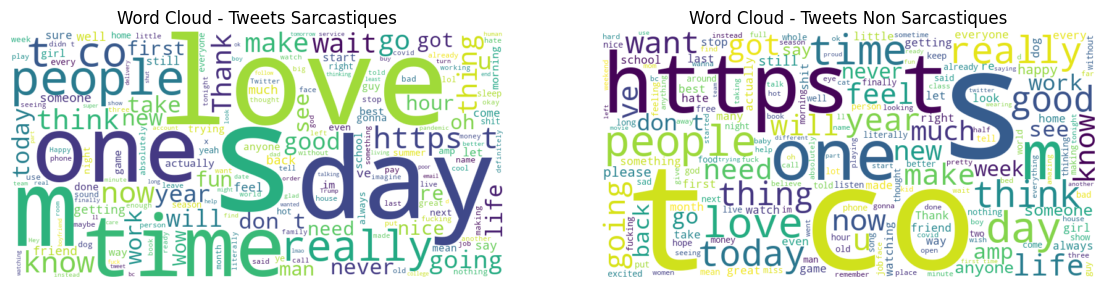

In [61]:
tweets_sarcastic = ' '.join(train_data[train_data['sarcastic'] == 1]['tweet'].astype(str))
tweets_non_sarcastic = ' '.join(train_data[train_data['sarcastic'] == 0]['tweet'].astype(str))
stopwords=set(STOPWORDS)
wordcloud_sarcastic = WordCloud(width=800, height=400, background_color='white', stopwords=stopwords).generate(tweets_sarcastic)
wordcloud_non_sarcastic = WordCloud(width=800, height=400, background_color='white', stopwords=stopwords).generate(tweets_non_sarcastic)
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_sarcastic, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - Tweets Sarcastiques')
plt.subplot(1, 2, 2)
plt.imshow(wordcloud_non_sarcastic, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - Tweets Non Sarcastiques')
plt.show()



***Prétraitement du texte***

In [62]:
train_data=train_data[["tweet","sarcastic"]]
train_data.head()

,tweet,sarcastic
0,The only thing I got from college is a caffein...,1
1,I love it when professors draw a big question ...,1
2,Remember the hundred emails from companies whe...,1
3,Today my pop-pop told me I was not “forced” to...,1
4,@VolphanCarol @littlewhitty @mysticalmanatee I...,1


1. Nettoyage et transformation du texte

In [63]:
def clean_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r"http\S+|www\S+", "", text)       
    text = re.sub(r"@\w+", "", text)                 
    text = re.sub(r"#", "", text)                    
    text = re.sub(r"[^a-zA-Z\s]", "", text)          
    text = re.sub(r"\s+", " ", text).strip()
    words = [word for word in text.split() if word not in stopwords]
    text = " ".join(words)

    return text


In [64]:
train_data['text_cleaned'] = train_data['tweet'].apply(clean_text)
train_data.head()

,tweet,sarcastic,text_cleaned
0,The only thing I got from college is a caffein...,1,thing got college caffeine addiction
1,I love it when professors draw a big question ...,1,love professors draw big question mark next an...
2,Remember the hundred emails from companies whe...,1,remember hundred emails companies covid starte...
3,Today my pop-pop told me I was not “forced” to...,1,today poppop told forced go college okay sure ...
4,@VolphanCarol @littlewhitty @mysticalmanatee I...,1,reported cancun cruz worrying heartbeats const...


In [65]:
train_data=clean_data(train_data)[['text_cleaned','sarcastic']]
train_data.head()

,text_cleaned,sarcastic
0,thing got college caffeine addiction,1
1,love professors draw big question mark next an...,1
2,remember hundred emails companies covid starte...,1
3,today poppop told forced go college okay sure ...,1
4,reported cancun cruz worrying heartbeats const...,1


***Vectorisation (transformation en nombres)***